# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Reshape, Dense, add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import random, math

# Import preprocessed train and test set

In [ ]:
x_train = np.load("/content/drive/MyDrive/CV/X_rgb_128_train.npy")
y_train = np.load("/content/drive/MyDrive/CV/Y_sketch_128_train.npy")
x_test = np.load("/content/drive/MyDrive/CV/X_rgb_128_test.npy")
y_test = np.load("/content/drive/MyDrive/CV/Y_sketch_128_test.npy")

x_train.shape,y_train.shape, x_test.shape, y_test.shape

((4000, 128, 128, 3),
 (4000, 128, 128, 1),
 (398, 128, 128, 3),
 (398, 128, 128, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

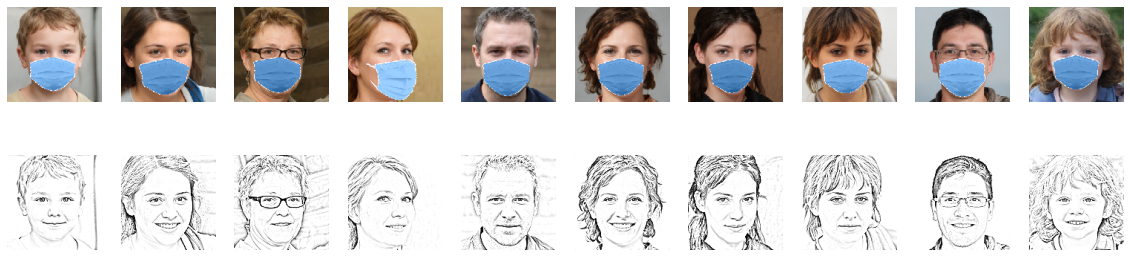

In [ ]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
nomasks = y_test[:10]
for i, (x,y) in enumerate(zip(masks[:10],nomasks[:10])):
    plt.subplot(2,10,i+1)
    plt.imshow(x,cmap='gray')
    plt.axis("OFF")
    
    plt.subplot(2,10,i+11)
    plt.imshow(y.reshape(128,128),cmap='gray')
    plt.axis("OFF")
plt.show()

# Data Augmentation

In [ ]:
class Daugmentation:
    def flip(img, t):
        if t[0]==0:
            return img
        else:
            return cv2.flip(img, t[1])

    def zoom(img, t):
        if t[2]==0:
            return img
        else:
            h, w = img.shape[:2]
            nh, nw =  int(t[3]*h), int(t[3]*w)
            dh, dw = h-nh, w-nw
            zimg = img[dh//2:nh+dh//2, dw//2:nw+dw//2]
            zimg = cv2.resize(zimg, (w,h))
            return zimg


    def get_ts(batch_size):
        return [[random.choice([0,1]),random.choice([-1,0,1]), random.randint(0,2),random.uniform(0.4,0.9)] for i in range(batch_size)]

    def aug(img,t):
        img = Daugmentation.flip(img,t)
        # img = Daugmentation.zoom(img, t)
        return img


class maSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, Daugmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = Daugmentation

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        ts = self.augment.get_ts(len(batch_x))
        return np.array([self.augment.aug(x,t) for x,t in zip(batch_x,ts)]),np.array([self.augment.aug(y,t) for y,t in zip(batch_y,ts)]) 

In [1]:
#x_test = x_test[:,:,:,0]
#x_train = x_train[:,:,:,0]
#y_test = y_test[:,:,:,0]
#y_train = y_train[:,:,:,0]

In [ ]:
batch_size=16

gotrain = maSequence(x_train, y_train.reshape(-1,128,128), batch_size,Daugmentation)
gotest = maSequence(x_test, y_test.reshape(-1,128,128), batch_size,Daugmentation)

# Model Building and Training

In [ ]:
def get_model():
    # encoder
    In = Input(shape=x_train[0].shape)
    c1 = Conv2D(32, 3, activation="relu", padding="same")(In)
    c1 = Conv2D(32, 3, activation="relu", padding="same")(c1)
#     c1 = Conv2D(32, 3, activation="relu", padding="same")(c1)
#     c1 = Conv2D(32, 3, activation="relu", padding="same")(c1)
    m1 = MaxPooling2D(2)(c1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(m1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(c2)
#     c2 = Conv2D(64, 3, activation="relu", padding="same")(c2)
#     c2 = Conv2D(64, 3, activation="relu", padding="same")(c2)
    m2 = MaxPooling2D(2)(c2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(m2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(c3)
#     c3 = Conv2D(128, 3, activation="relu", padding="same")(c3)
#     c3 = Conv2D(128, 3, activation="relu", padding="same")(c3)
    m3 = MaxPooling2D(2)(c3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(m3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(c4)
#     c4 = Conv2D(256, 3, activation="relu", padding="same")(c4)
#     c4 = Conv2D(256, 3, activation="relu", padding="same")(c4)
    u1 = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(c4)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(u1)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(c5)
#     c5 = Conv2D(128, 3, activation="relu", padding="same")(c5)
#     c5 = Conv2D(128, 3, activation="relu", padding="same")(c5)
    a1 = add([c5,c3])
    u2 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(a1)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(u2)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(c6)
#     c6 = Conv2D(64, 3, activation="relu", padding="same")(c6)
#     c6 = Conv2D(64, 3, activation="relu", padding="same")(c6)
    a2 = add([c6,c2])
    u3 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(a2)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(u3)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(c7)
#     c7 = Conv2D(32, 3, activation="relu", padding="same")(c7)
#     c7 = Conv2D(32, 3, activation="relu", padding="same")(c7)
    a3 = add([c7,c1])
    Out = Conv2D(1, 3, activation="sigmoid", padding="same")(a3)
    
    model = Model(In,Out)
    adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam,loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

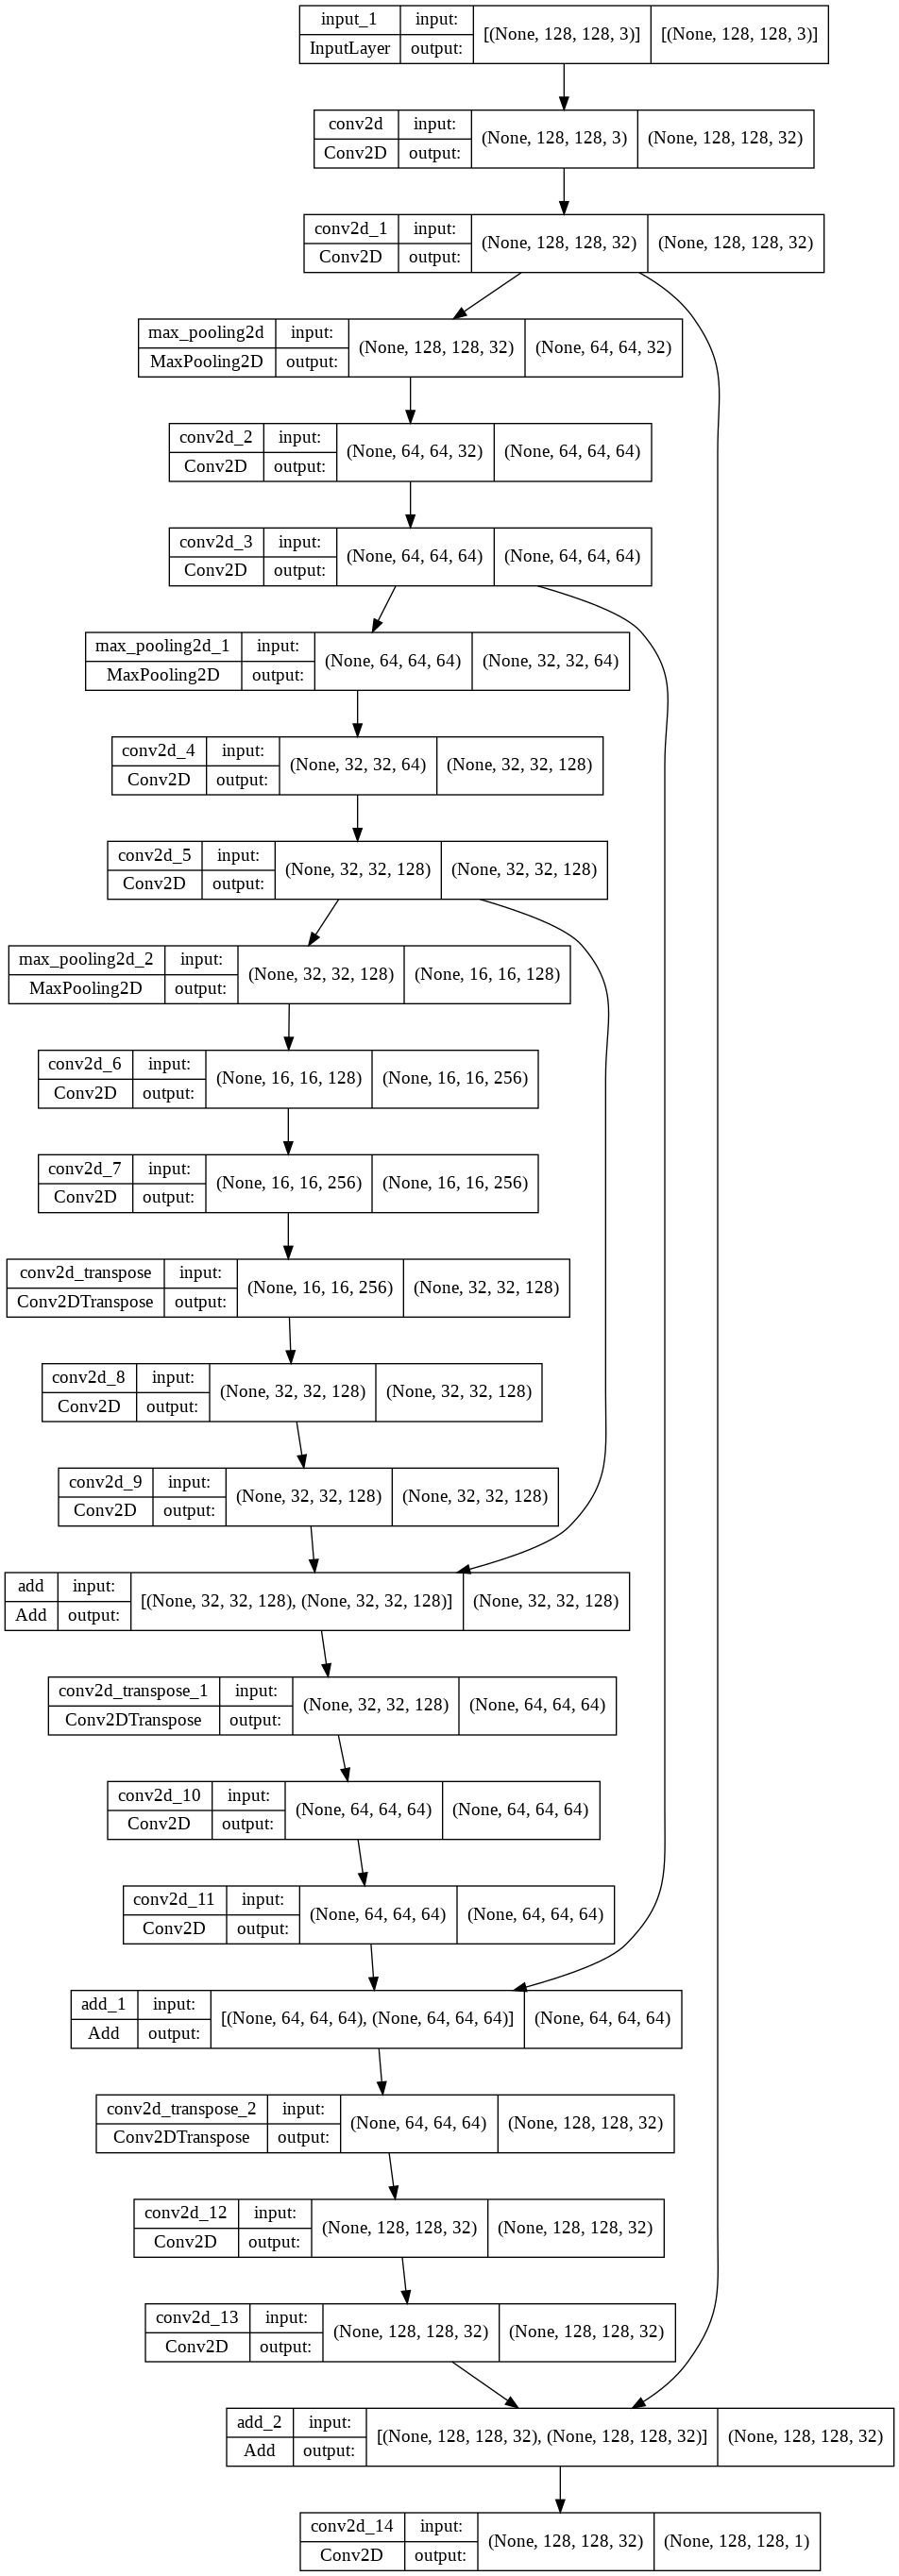

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
  checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CV/best_final_rgb_sketch.h5', verbose=0, save_best_only=True)
  history = model.fit_generator(generator=gotrain,
                                steps_per_epoch=gotrain.__len__(),
                                epochs=100,
                                
                                callbacks=[checkpointer],
                                validation_data=gotest,
                                validation_steps=gotest.__len__())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
250/250 [==============================] - 1296s 5s/step - loss: 0.2378 - accuracy: 0.0118 - val_loss: 0.1646 - val_accuracy: 0.0144
Epoch 2/100
250/250 [==============================] - 1294s 5s/step - loss: 0.1257 - accuracy: 0.0179 - val_loss: 0.1231 - val_accuracy: 0.0183
Epoch 3/100
189/250 [=====================>........] - ETA: 5:09 - loss: 0.1054 - accuracy: 0.0190

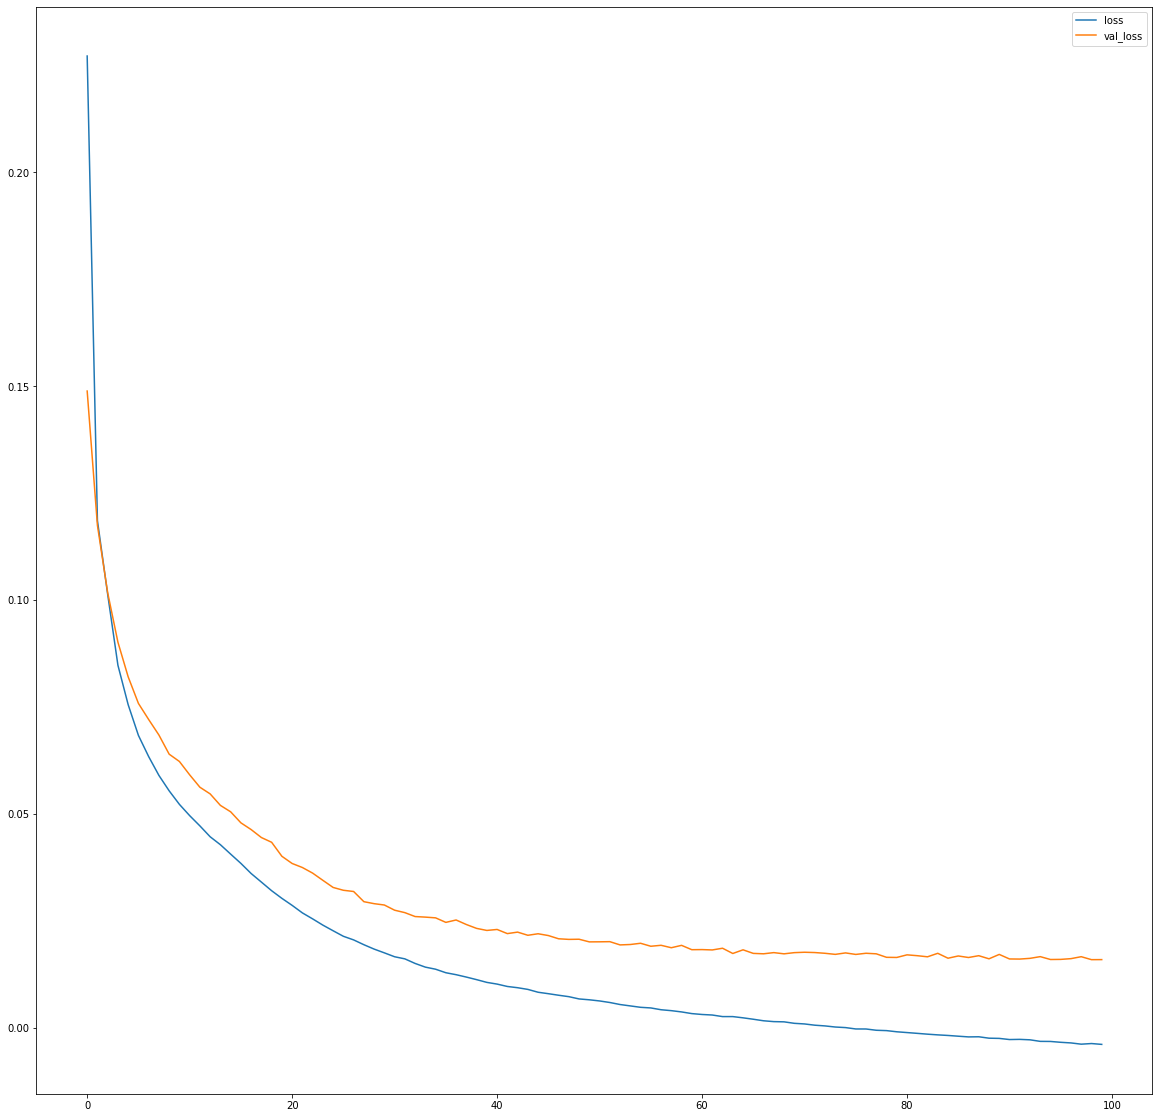

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])
plt.show()

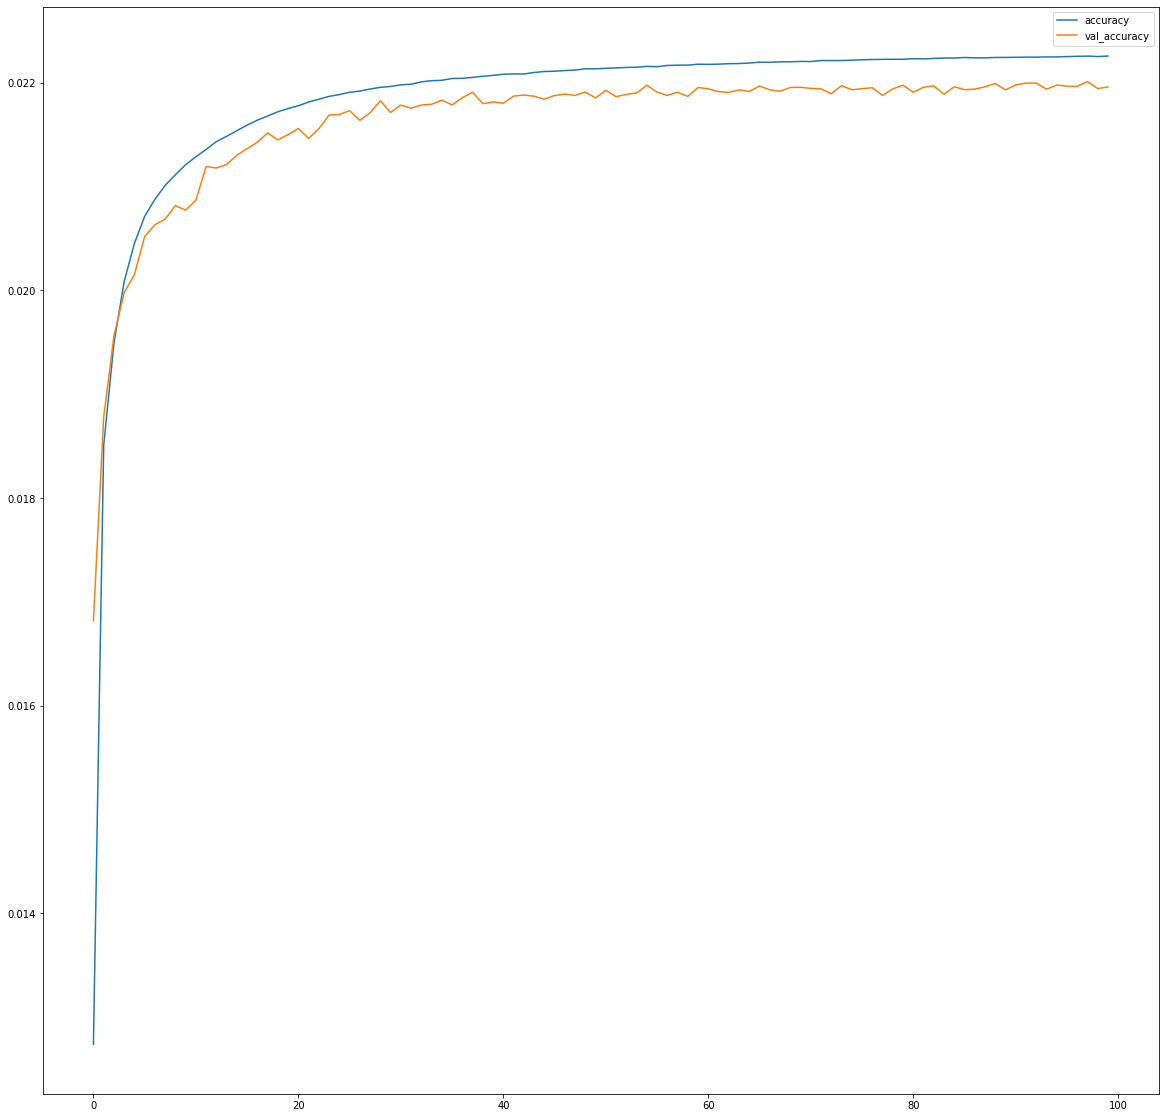

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])
plt.show()

# Generate Images

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/CV/best_final_rgb_sketch.h5")

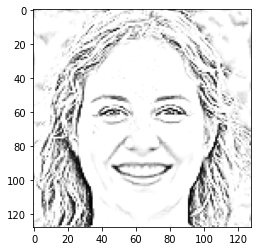

In [ ]:
nomask_preds = model.predict(x_test[10].reshape(-1,128,128,3))
plt.imshow(nomask_preds[0][:,:,0],cmap='gray')

In [ ]:
x_test.shape

(398, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

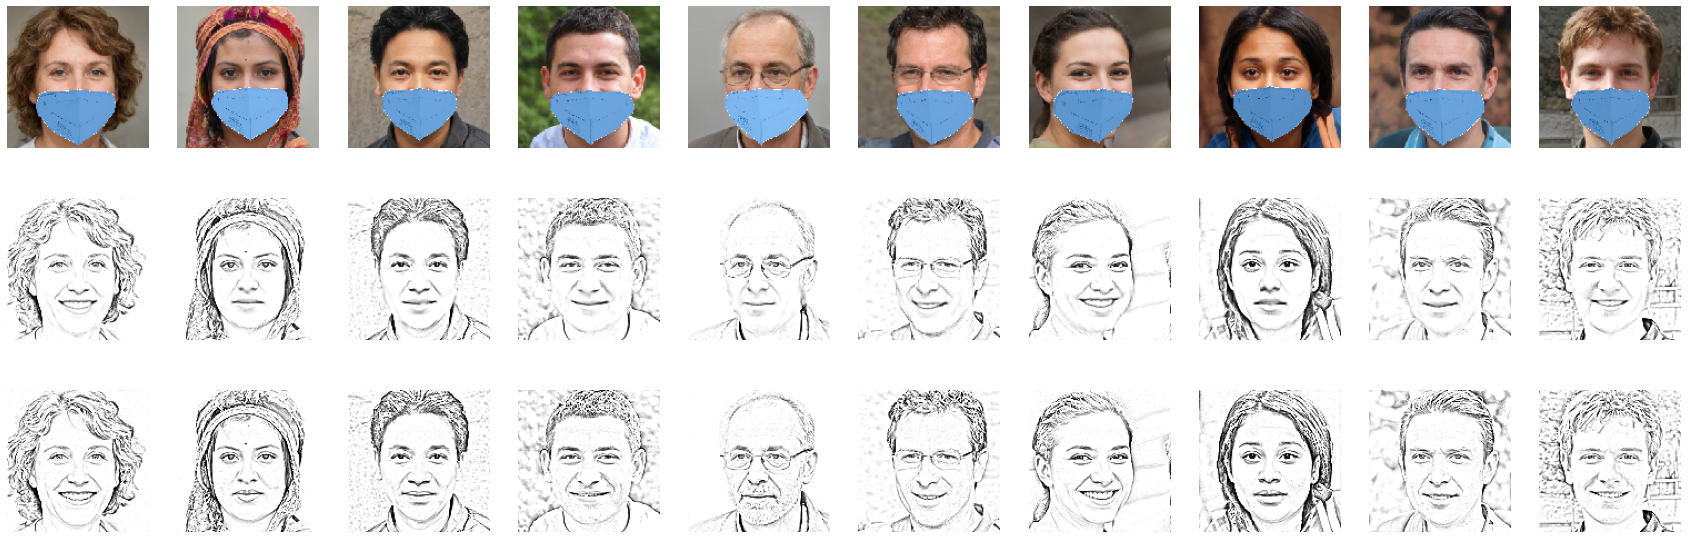

In [ ]:
plt.figure(figsize=(30,10))
masks = x_test[320:330]
nomask_preds = model.predict(masks.reshape(-1,128,128,3))
nomask_actuals = y_test[320:330]
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(masks[i],cmap='gray')
    plt.axis("OFF")
    
    plt.subplot(3,10,i+11)
    plt.imshow(nomask_preds[i].reshape(128,128),cmap='gray')
    plt.axis("OFF")
    
    plt.subplot(3,10,i+21)
    plt.imshow(nomask_actuals[i].reshape(128,128),cmap='gray')
    plt.axis("OFF")
plt.show()